In [3]:
cd '/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting'

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting


In [4]:
# %load src/main.py
'''
See notebooks/EDA.ipynb for plots

Import scripts from other .py files
'''
from src.State_Comparison import Comparable_States, Combined_State_Analysis, state_analysis, Predictions
from src.reg_model_class import reg_model
from src.data_clean_script import clean_data, replace_initial_values, replace_with_moving_averages, load_and_clean_data, create_spline, convert_to_date, fill_na_with_surround, get_moving_avg_df
from src.Misc_functions import series_to_supervised, generate_prediction_df, normalize_days

import pandas as pd
import numpy as np
import datetime

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

#Define minimum threshold of cases per 1 million people in each state to begin training data on.
#Threshold is the minimum value at which data is output; Used to reduce misleading predictions
#(low new cases count and low social distancing parameters before pandemic)
threshold = 450

def state_plot(state, df):
    fig, axes = plt.subplots(8, 1, figsize=(12, 15))
    for i, ax in enumerate(axes, 2):
        query = df[df['state'] == state]['days_elapsed']
        x = query.values
        y = covid_df.loc[query.index].iloc[:, i]
        ax.plot(x, y)
    fig.show()

if __name__ == '__main__':
    state = 'Minnesota'

    covid_df = load_and_clean_data()
    Similar_States_Init = Comparable_States()
    Similar_States_Init.make_master_pop_dens_df()
    sim_states_df = Similar_States_Init.get_similar_states(
        state_to_predict=state, recovery_factor_min=1.2, pop_density_tolerance=25)
    similar_states = sim_states_df.index.values
    State_Compile = Combined_State_Analysis(similar_states, print_err=True, normalize_day = False)
    State_Compile.get_feature_importances().T
    print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
        state, similar_states, state))
    Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile, normalize = False)
    #Plots in notebooks/EDA.ipynb


rmse: 9.048613502341716
The Most similar states to Minnesota that meet the comparable parameters are: ['Colorado' 'Iowa' 'Oklahoma' 'Vermont' 'Missouri']. These will be used to predict for Minnesota.


In [5]:
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

In [4]:
state_list = Prediction_Insights.similar_states
similar_to_MN_df = Prediction_Insights.similar_df.drop_duplicates()

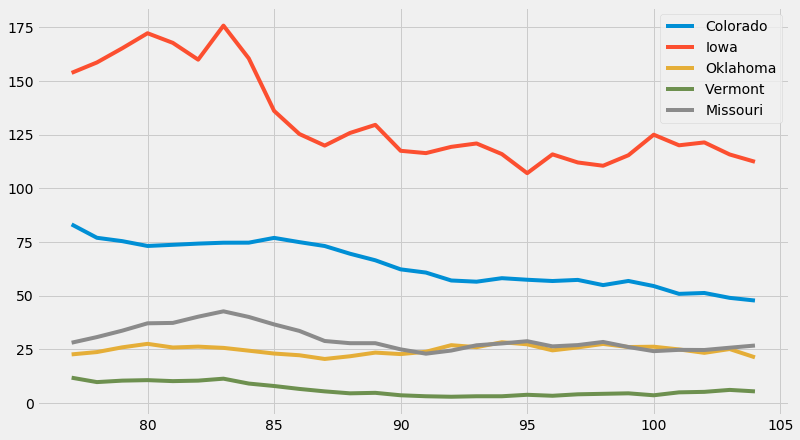

In [5]:

fig, ax = plt.subplots(figsize = (12, 7))
i = 0
for each in similar_to_MN_df['pop_density(t)'].unique():
    sub_df = similar_to_MN_df[similar_to_MN_df['pop_density(t)'] == each].copy()
    sub_df.sort_values(['days_elapsed(t)'], inplace = True)
    x = sub_df['days_elapsed(t)'].values
    y = sub_df['New_Cases_per_pop(t)'].values
    ax.plot(x, y, label = state_list[i])
    i += 1
ax.legend()

In [ ]:
indices = similar_to_MN_df[similar_to_MN_df['pop_density(t)'] == similar_to_MN_df['pop_density(t)'].unique()[3]]['days_elapsed(t)'].index
similar_to_MN_df['days_elapsed(t)'].loc[indices] += 30

In [8]:
MN_df = covid_df[covid_df['state'] == 'Minnesota']
IA_df = covid_df[covid_df['state'] == 'Iowa']
MN_df = replace_with_moving_averages(MN_df, ['New_Cases_per_pop'], 0)
IA_df = replace_with_moving_averages(IA_df, ['New_Cases_per_pop'], 0)

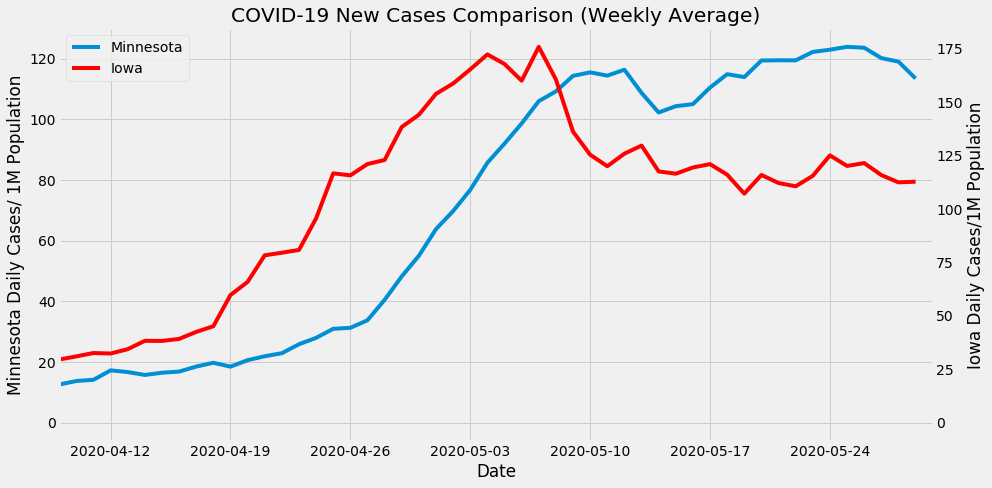

In [11]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize = (14, 7))
x = MN_df['days_elapsed']
y = MN_df['New_Cases_per_pop']
ax.plot(x.apply(convert_to_date), y, label = 'Minnesota')
ax.set_ylabel('{} Daily Cases/ 1M Population'.format('Minnesota'))
ax.set_xlim(convert_to_date(54), convert_to_date(105))
ax.set_xlabel('Date')
ax.set_title('COVID-19 New Cases Comparison (Weekly Average)')
x = IA_df['days_elapsed']
y = IA_df['New_Cases_per_pop']

ax2 = ax.twinx()
ax2.plot(x.apply(convert_to_date), y, label = 'Iowa', c = 'red')
ax2.set_ylabel('{} Daily Cases/1M Population'.format('Iowa'))
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc = 2)
ax2.grid(None)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
fig.tight_layout()
fig.savefig('images/MN_IA', dpi = 300)


In [ ]:
states = ['Vermont']
x_starts, VT_df = normalize_days(states, covid_df, percent_max = 0.25, plot = False, save_x_starts = True)
VT = VT_df[0]
VT['days_since_start'] += 30
# plt.plot(VT_df['days_since_start'].values, VT_df['New_Cases_per_pop'].values)

In [ ]:
import numpy as np

states = ['Minnesota', 'Iowa', 'Colorado', 'Missouri', 'Oklahoma']

x_starts, df = normalize_days(states, covid_df, percent_max = 0.25, plot = True, save_x_starts = True)
plt.plot(VT['days_since_start'].values, VT['New_Cases_per_pop'].values, label = 'Vermont')
plt.legend()
plt.xlabel('Days Since 25% of Maximum Infections')
plt.ylabel('Daily New Cases per 1M Pop')

In [14]:
x_starts

[70, 63, 39, 40, 40]

In [15]:
normalized_df = VT.copy()
normalized_df = normalized_df.append(df)

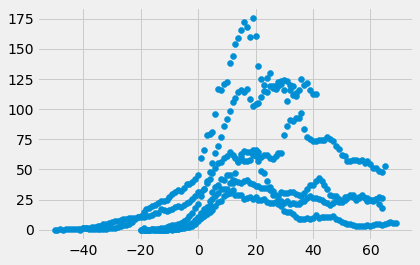

In [16]:
plt.scatter(normalized_df['days_since_start'], normalized_df['New_Cases_per_pop'])

In [17]:
normalized_df.drop('state', axis = 1, inplace = True)

In [18]:
values = normalized_df.values
num_cols = len(normalized_df.columns)
ts_frame_data = series_to_supervised(values, normalized_df.columns, 21, 1)
ts_frame_data = ts_frame_data.iloc[:,
                                    num_cols-1:-num_cols + 1:num_cols].join(ts_frame_data.iloc[:, -num_cols:])
ts_frame_data = ts_frame_data[ts_frame_data['days_since_start(t)'] >= 10]
ts_y = ts_frame_data.pop('New_Cases_per_pop(t)')
ts_x = ts_frame_data

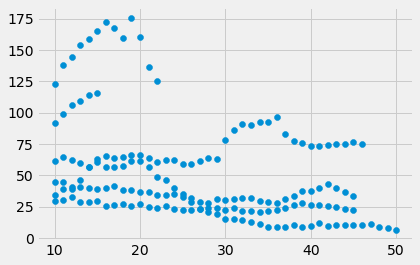

In [19]:
plt.scatter(ts_x['days_since_start(t)'], ts_y)

In [20]:
ts_x.rename(columns = {'days_since_start(t)' : 'days_elapsed(t)'}, inplace = True)

In [21]:
rf_model = reg_model(ts_x, ts_y)
rf_model.rand_forest(n_trees = 100)
rf_model.evaluate_model(print_err_metric = True)

rmse: 6.351880535269192


6.351880535269192

In [22]:
MN_df = normalized_df[normalized_df['state'] == 'Minnesota']
# normalized_df = normalized_df[normalized_df['state'] != 'Minnesota']

KeyError: 'state'

In [23]:
min_vals = normalized_df.min().iloc[2:9]
max_vals = normalized_df.max().iloc[2:9]
max_SD = list(min_vals[:5])
max_SD.extend([max_vals[5], min_vals[6]])
min_SD = list(max_vals[:5])
min_SD.extend([min_vals[5], max_vals[6]])

In [24]:
MN_df
values = MN_df.values
num_cols = len(MN_df.columns)
ts_frame_data = series_to_supervised(values, MN_df.columns, 21, 1)
ts_frame_data = ts_frame_data.iloc[:,num_cols-1:-num_cols + 1:num_cols].join(ts_frame_data.iloc[:, -num_cols:])

MN_ts_y = ts_frame_data.pop('New_Cases_per_pop(t)')
MN_ts_x = ts_frame_data
MN_ts_x.rename(columns = {'days_since_start(t)' : 'days_elapsed(t)'}, inplace = True)

In [25]:
high, low = max_SD, min_SD
columns = ['Retail/Recreation %', 'Grocery/Pharmacy %', 'Parks %',
           'Transit Stations %', 'Workplaces %', 'Residential %', 'Driving %']
SD_Table = round(pd.DataFrame(
    [np.array(high), np.array(low)], columns=columns) * 100, 2)
SD_Table[''] = ['High', 'Low']
SD_Table.set_index('', inplace=True)

In [26]:
def denormalize_date(x, x_start, extra = 0):
    return convert_to_date(x + x_start + extra)

In [27]:
MN_ts_x.drop('state(t)', axis = 1, inplace = True)

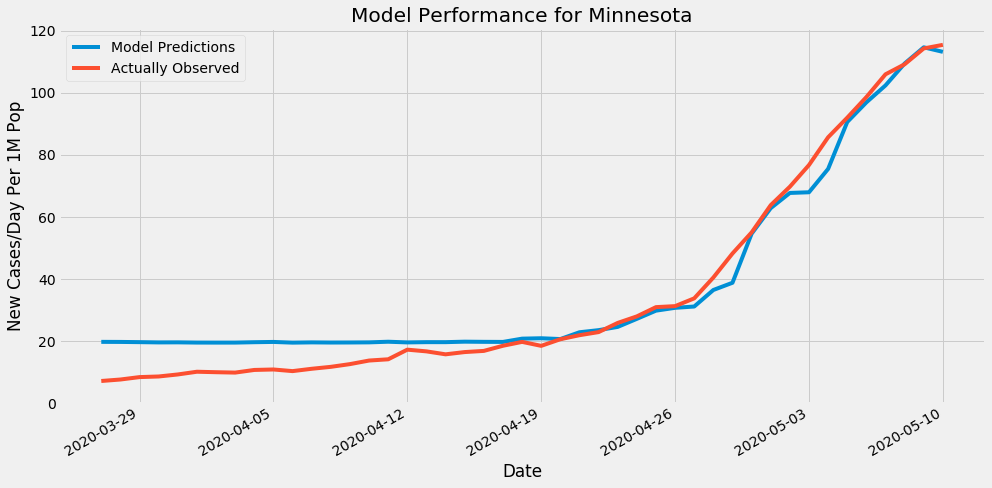

In [38]:
fig, ax = plt.subplots(figsize=(14, 7))
x = MN_ts_x['days_elapsed(t)']
ax.plot(x.apply(convert_to_date), rf_model.model.predict(MN_ts_x), label='Model Predictions')
ax.plot(x.apply(convert_to_date), MN_ts_y, label='Actually Observed')
ax.set_ylim(0)
ax.legend()
ax.set_title('Model Performance for {}'.format('Minnesota'))
ax.set_xlabel('Date')
ax.set_ylabel('New Cases/Day Per 1M Pop')
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
fig.autofmt_xdate(rotation=30)
fig.tight_layout()
fig.savefig('images/MN_perf')

In [5]:
high_pred = generate_prediction_df(max_SD, MN_ts_x, MN_ts_y, predictions=21, rf = rf_model)
fig, ax = plt.subplots(figsize=(14, 7))
labels = ['High Social Distancing', 'Low Social Distancing']
x = high_pred[0]['days_elapsed(t)']
x.apply(lambda x: x + 88)
y = high_pred[1]

ax.plot(MN_ts_x['days_elapsed(t)'], MN_ts_y, label = 'Past Data', c = 'black')
ax.plot(x.values, y, label= 'High Social Distancing')

low_pred = generate_prediction_df(min_SD, MN_ts_x, MN_ts_y, predictions=21, rf=rf_model)
x = low_pred[0]['days_elapsed(t)']
y = low_pred[1]
# ax.plot(x[x >= 15], y[x >= 15], label='Low Social Distancing')

ax.legend()
ax.set_title('Future Predicted Daily New Cases'.format('Minnesota'))
ax.set_xlabel('Date')
ax.set_ylabel('New Cases/Day Per 1M Pop')
# ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
# fig.autofmt_xdate(rotation=30)
fig.tight_layout()

NameError: name 'max_SD' is not defined

In [104]:
convert_to_date(104)

datetime.date(2020, 5, 29)

In [26]:
covid_df = load_and_clean_data()
Similar_States_Init = Comparable_S

fig, ax = plt.subplots(figsize = (14, 7))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['blue', 'grey', 'blue', 'blue', 'blue', 'blue', 'gray', 'grey', 'blue']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
plt.yscale('log')
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 20)
fig.tight_layout()
fig.savefig('images/MN_Feat')

,state,days_since_start,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,pop_density,New_Cases_per_pop
3829,Vermont,-14,1.10,1.00,1.28,1.25,1.02,0.99,1.4859,68.141586,0.000000
3830,Vermont,-13,1.13,1.11,1.49,1.13,1.04,0.98,1.2617,68.141586,0.000000
3831,Vermont,-12,1.09,1.09,1.52,1.08,0.99,1.00,1.0102,68.141586,0.000000
3832,Vermont,-11,1.01,1.03,1.02,1.03,0.99,1.01,0.9711,68.141586,0.000000
3833,Vermont,-10,1.03,1.05,0.96,1.02,0.99,1.01,0.9578,68.141586,1.592202
...,...,...,...,...,...,...,...,...,...,...,...
3908,Vermont,65,0.77,0.88,2.62,0.50,0.26,1.19,0.9709,68.141586,5.004064
3909,Vermont,66,0.84,0.97,2.30,0.72,0.58,1.13,1.0707,68.141586,5.231521
3910,Vermont,67,0.84,0.97,2.25,0.73,0.59,1.14,1.1016,68.141586,6.141351
3911,Vermont,68,0.80,0.93,1.79,0.74,0.61,1.14,1.0433,68.141586,5.458978


100

In [106]:
104-15

89

In [8]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 18})
plt.style.use('fivethirtyeight')
plt.close('all')


In [9]:
State_Compile.get_feature_importances().T

,Daily_Cases_per_pop(t-21),Daily_Cases_per_pop(t-20),Daily_Cases_per_pop(t-19),Daily_Cases_per_pop(t-18),Daily_Cases_per_pop(t-17),Daily_Cases_per_pop(t-16),Daily_Cases_per_pop(t-15),Daily_Cases_per_pop(t-14),Daily_Cases_per_pop(t-13),Daily_Cases_per_pop(t-12),...,Daily_Cases_per_pop(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t),pop_density(t)
0,0.003058,0.003575,0.008782,0.005365,0.004407,0.010122,0.002709,0.002239,0.010028,0.009384,...,0.103741,0.0019,0.001335,0.00203,0.207172,0.003108,0.003332,0.016447,0.002102,0.040088


Index(['Days Elapsed', 'Retail And Recreation', 'Grocery And Pharmacy',
       'Parks', 'Transit Stations', 'Workplaces', 'Residential', 'Driving',
       'Pop Density'],
      dtype='object')

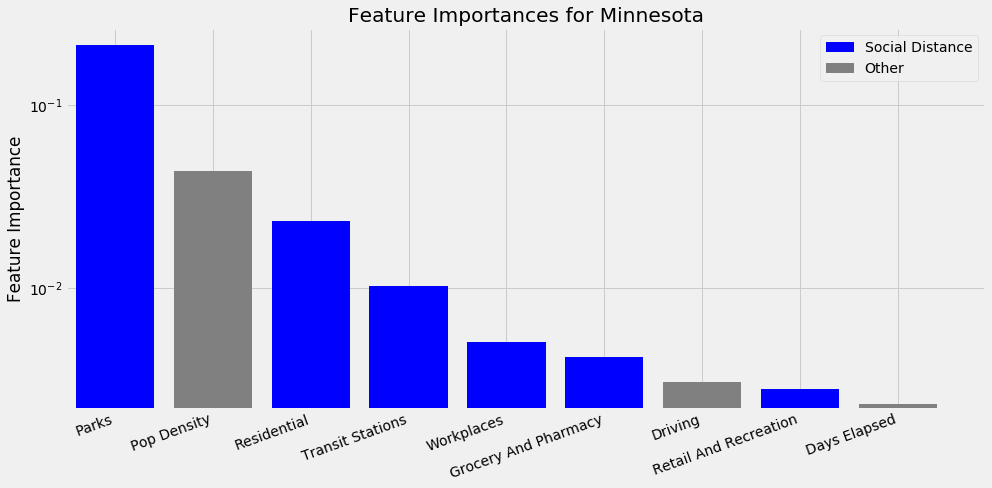

In [49]:
fig, ax = plt.subplots(figsize = (14, 7))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
colors = ['grey', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'grey', 'grey']
cols = feat_importance.columns
colorDict = {col: color for col, color in zip(cols, colors)}
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = [colorDict[each] for each in feat_importance]
labels = ['Social Distancing', 'Other']
ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors, label = 'Social Distance')
plt.yscale('log')
ax.set_title('Feature Importances for {}'.format(state))
ax.bar([-1],[0.003], color = 'grey', label = 'Other')
ax.set_xlim(-0.5)
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 20)
fig.tight_layout()
ax.legend()
fig.savefig('images/MN_Feat')

In [11]:
Recov_df = round(Similar_States_Init.master_pop_density_df.loc[np.append(similar_states, state)], 1)
Recov_df.rename(columns = {'pop_density': 'People/Square Mile'}, inplace = True)
Recov_df.index.name = 'State'

In [12]:
Recov_df

,People/Square Mile,Recovery Factor
State,,
Colorado,56.4,2.0
Iowa,56.9,1.6
Oklahoma,57.7,1.4
Vermont,68.1,12.1
Missouri,89.7,1.6
Minnesota,71.6,1.0


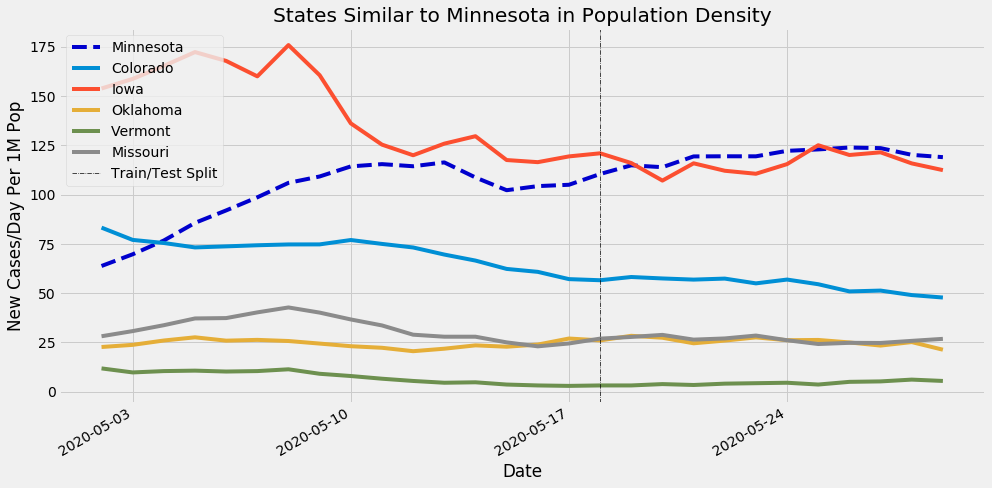

In [4]:
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

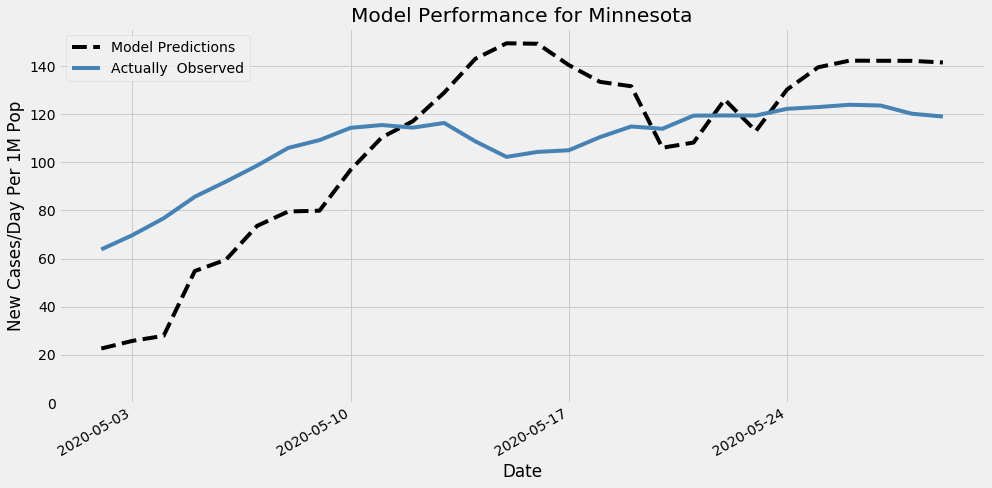

In [5]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

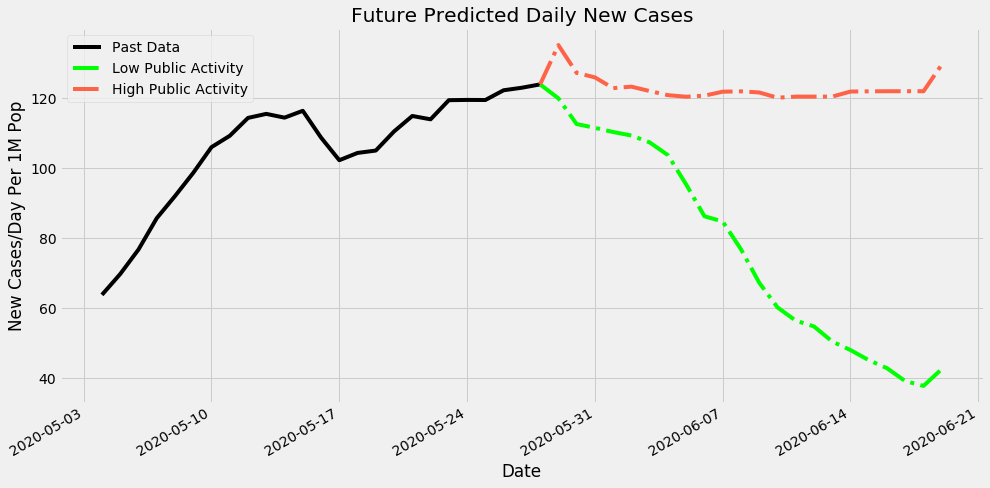

In [11]:
Prediction_Insights.forecast_to_future(save = 'images/forecast3for{}'.format(state))

In [7]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [8]:
round(SD_Table, 1)

,Retail/Recreation %,Grocery/Pharmacy %,Parks %,Transit Stations %,Workplaces %,Residential %,Driving %
,,,,,,,
High,52.7,74.0,94.1,43.3,50.1,119.4,55.8
Low,93.9,117.0,229.9,96.1,72.7,108.6,124.7


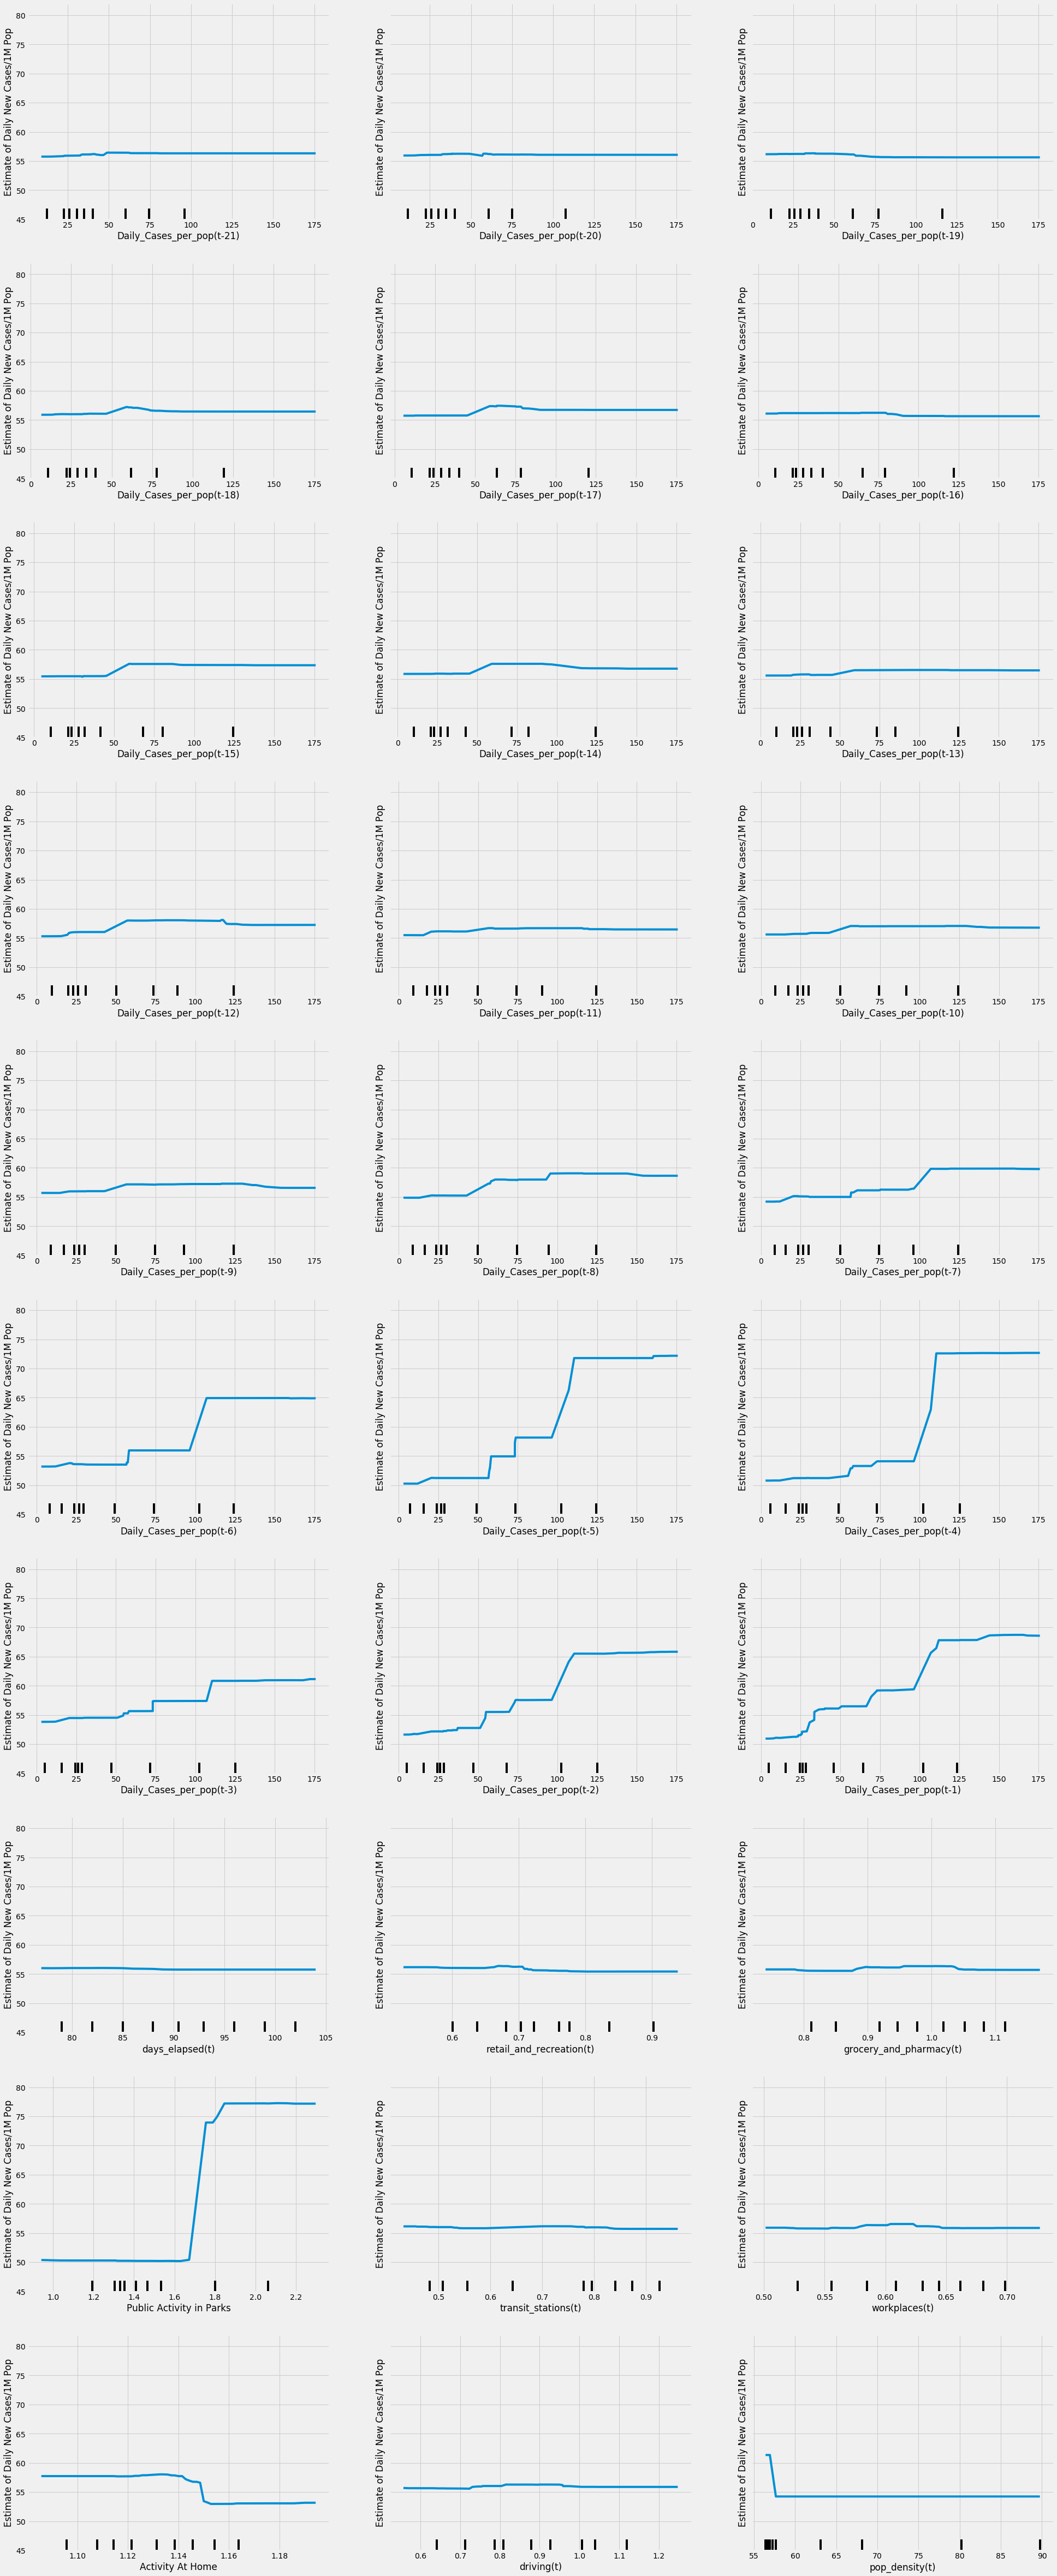

In [12]:
from sklearn.inspection import plot_partial_dependence
State_Compile.X.rename(columns = {'parks(t)': 'Public Activity in Parks', 'residential(t)': 'Activity At Home'}, inplace = True)
fig = plot_partial_dependence(State_Compile.rf.model, State_Compile.X, State_Compile.X.columns, grid_resolution = 500)
fig = plt.gcf()
axes = fig.get_axes()
for ax in axes:
    ax.set_ylim(45, 82)
    ax.set_ylabel('Estimate of Daily New Cases/1M Pop')
fig.set_figwidth(30)
fig.set_figheight(80)

# fig.subplots_adjust(wspace=0.4, hspace=0.3)

In [13]:
fig.savefig('images/MNPartialDep3', dpi = 300)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5278a898>,
      dtype=object)

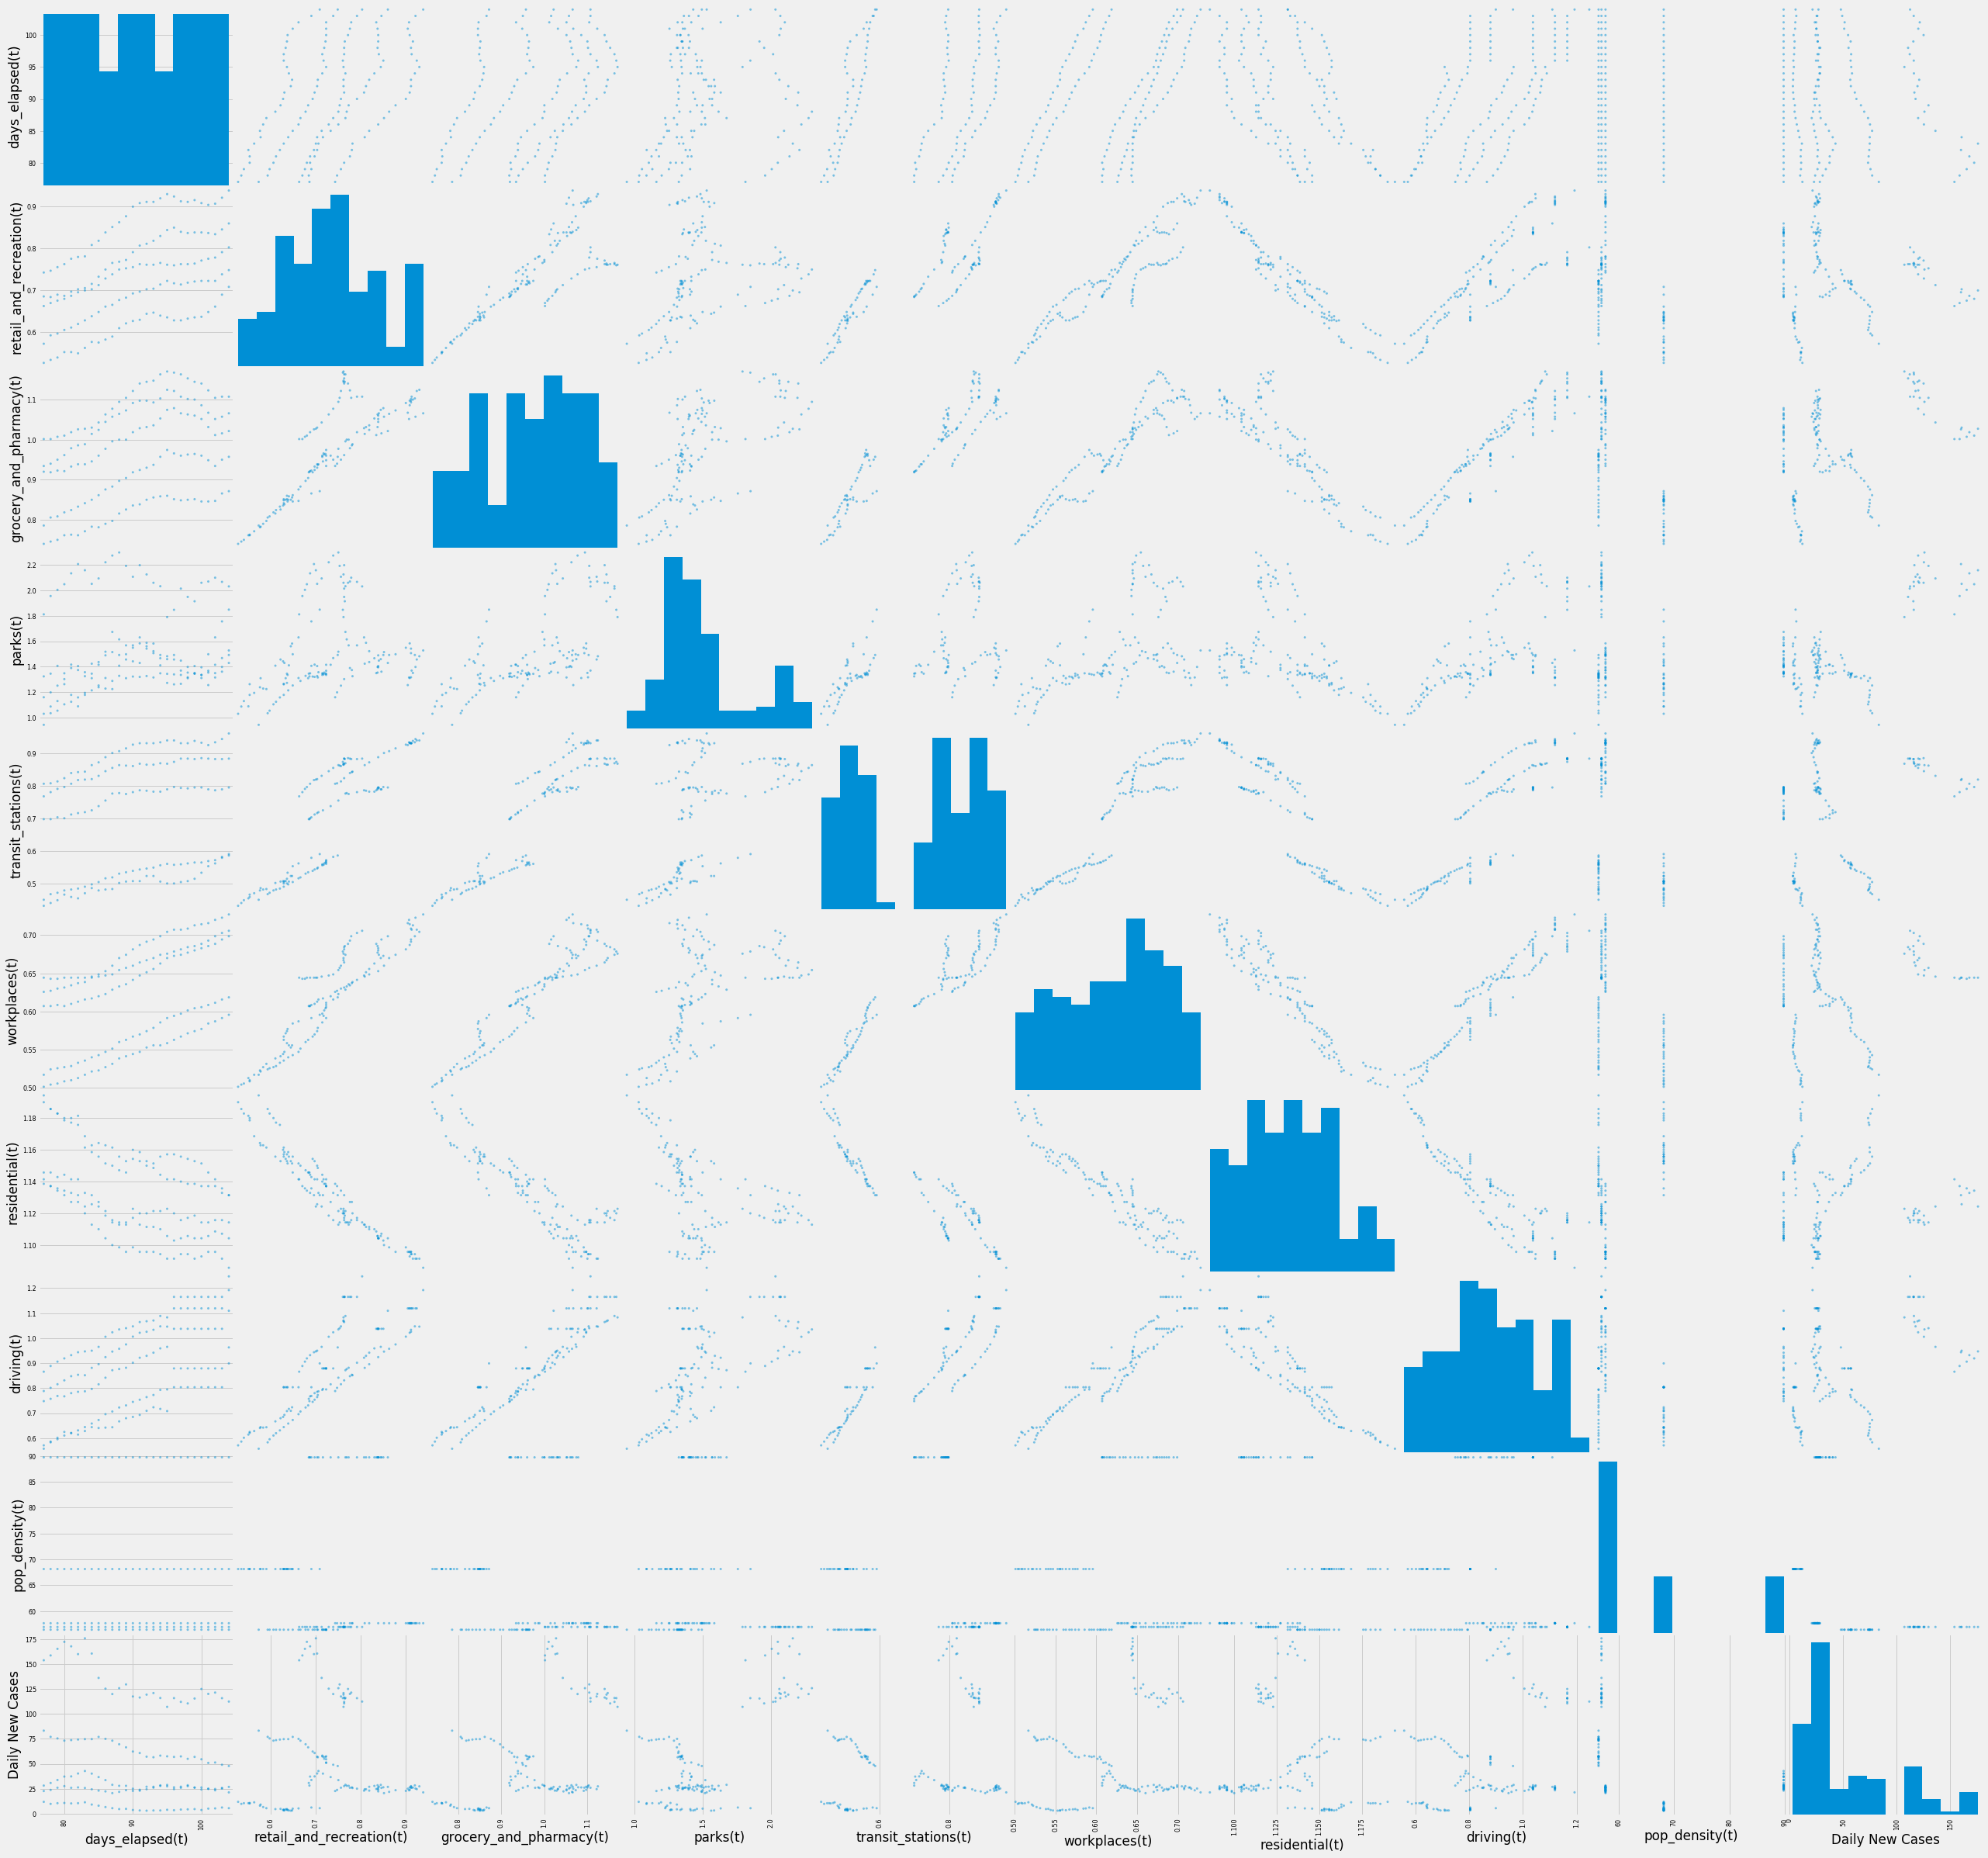

In [633]:
## from pandas.plotting import scatter_matrix
total = State_Compile.X.iloc[:,-9:].copy()
total['Daily New Cases'] = State_Compile.y
scatter_matrix(total, figsize = (40,40))

Text(0.5, 0.98, 'MN Social Distancing Features')

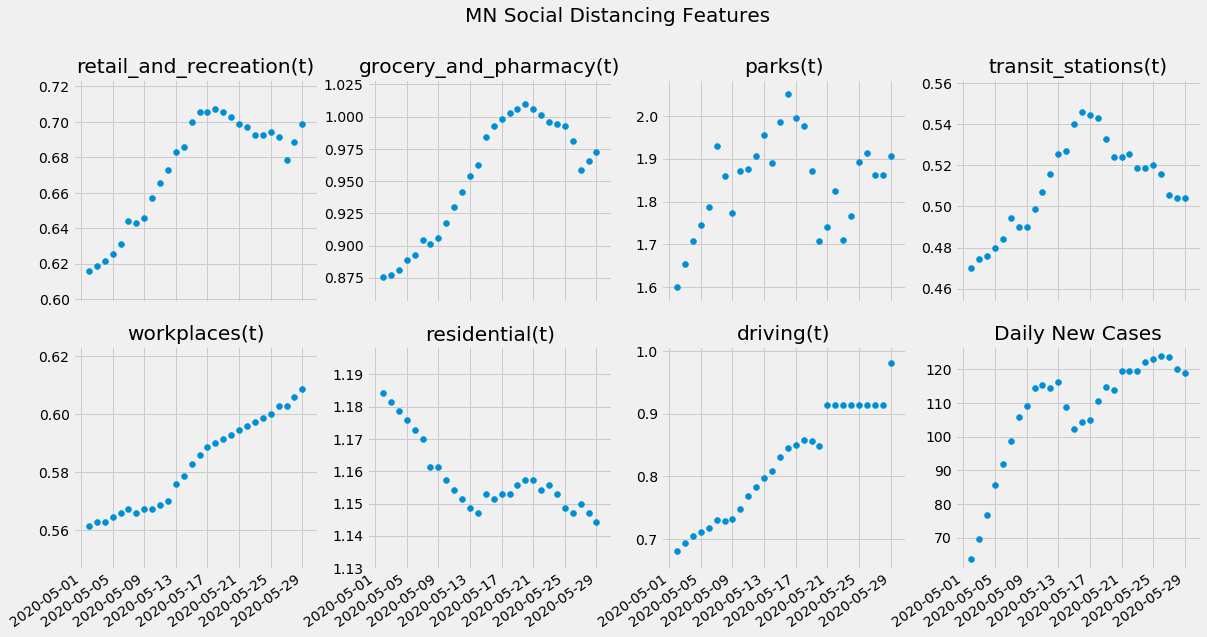

In [72]:
SD_time = Prediction_Insights.State_Analysis_X.iloc[:, -9:-1]
x = SD_time['days_elapsed(t)']
fig, axes = plt.subplots(2, 4, figsize = (18, 10))
for i, ax in enumerate(axes.flatten(), 1):
    try:
        ax.scatter(x.apply(convert_to_date), SD_time.iloc[:,i])
        ax.set_title(SD_time.columns[i])
    except:
        ax.scatter(x.apply(convert_to_date), Prediction_Insights.State_Analysis_y)
        ax.set_title('Daily New Cases')
    ax.set_xlim(convert_to_date(75), convert_to_date(106))
    
fig.autofmt_xdate(rotation = 35)
fig.suptitle("MN Social Distancing Features", fontsize=20)

In [74]:
fig.savefig('images/MN_SocialD', dpi = 300)

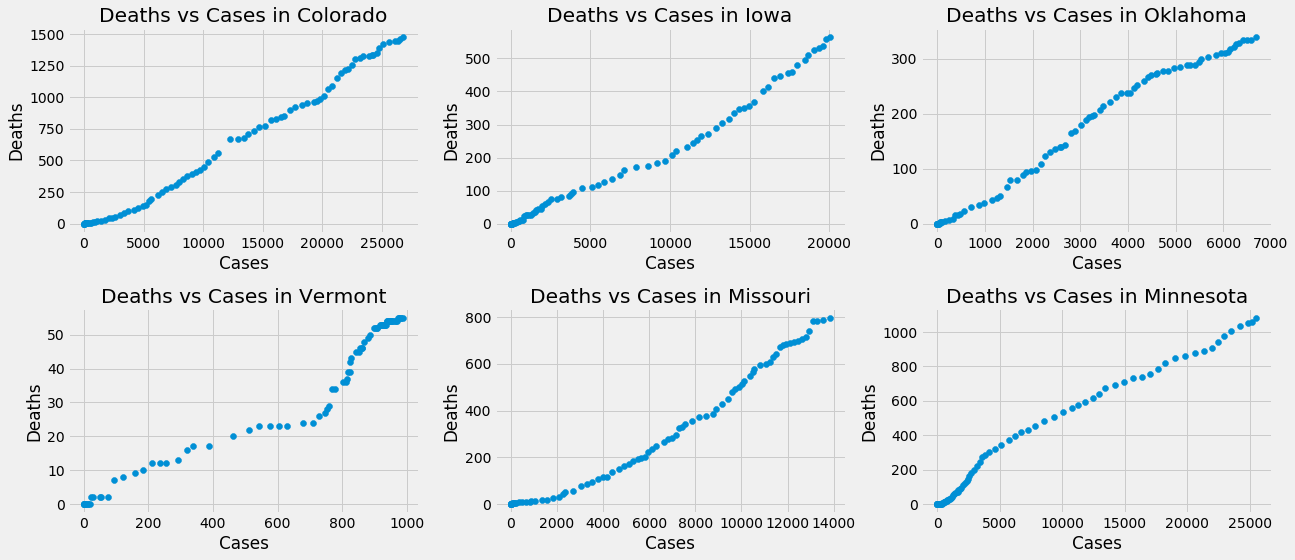

In [79]:
# Plot state deaths vs cases
def raw_state_data(states):
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    state_raw_list = []
    for state in states:
        state_raw_list.append(covid_raw_df[covid_raw_df['state'] == state])
    return state_raw_list

fig, axes = plt.subplots(2, 3, figsize = (18,8))
similar_states = np.append(similar_states, 'Minnesota')
state_list = raw_state_data(similar_states)

for i, ax in enumerate(axes.flatten()):
    try:
        state_name = state_list[i]['state'].unique()[0]
        ax.scatter(state_list[i]['cases'], state_list[i]['deaths'])
        ax.set_title('Deaths vs Cases in {}'.format(state_name))
        ax.set_xlabel('Cases')
        ax.set_ylabel('Deaths')
    except:
        continue
fig.tight_layout()
# Mostly linear trend between cases and deaths
fig.savefig('images/DeathVsCases', dpi = 300)

In [8]:
state = 'Colorado'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 2, pop_density_tolerance=25)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 6.811271993116912
The Most similar states to Colorado that meet the comparable parameters are: ['Kansas' 'Oregon' 'Colorado' 'Vermont']. These will be used to predict for Colorado.


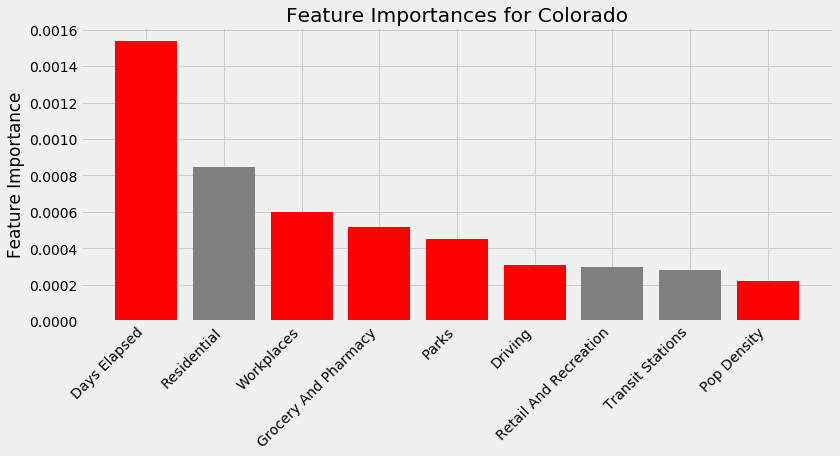

In [15]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
fig.savefig('images/MN_Feat')

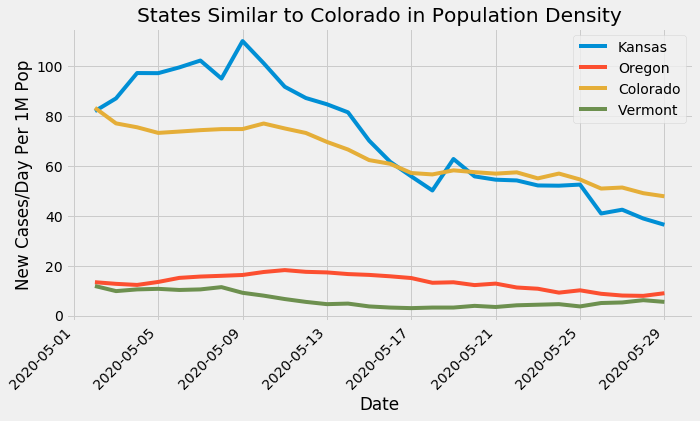

In [10]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

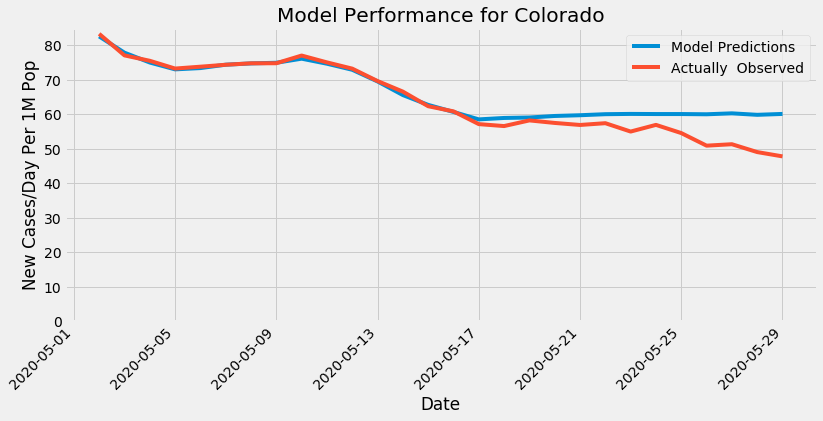

In [11]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

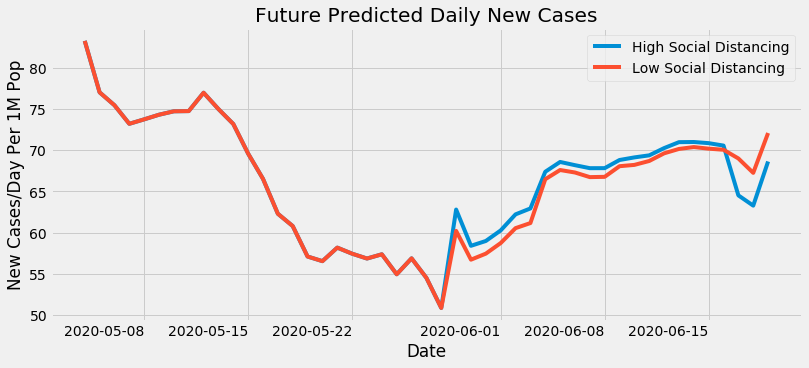

In [12]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [13]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [14]:
SD_Table

,Retail/Recreation %,Grocery/Pharmacy %,Parks %,Transit Stations %,Workplaces %,Residential %,Driving %
,,,,,,,
Low,52.71,74.00,94.14,43.29,50.14,119.43,55.75
High,83.57,103.57,217.71,93.43,70.14,110.00,117.09


In [57]:
state = 'California'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 1.5, pop_density_tolerance= 100)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 7.313866980494069
The Most similar states to California that meet the comparable parameters are: ['Michigan' 'Indiana' 'Hawaii' 'Pennsylvania' 'Ohio']. These will be used to predict for California.


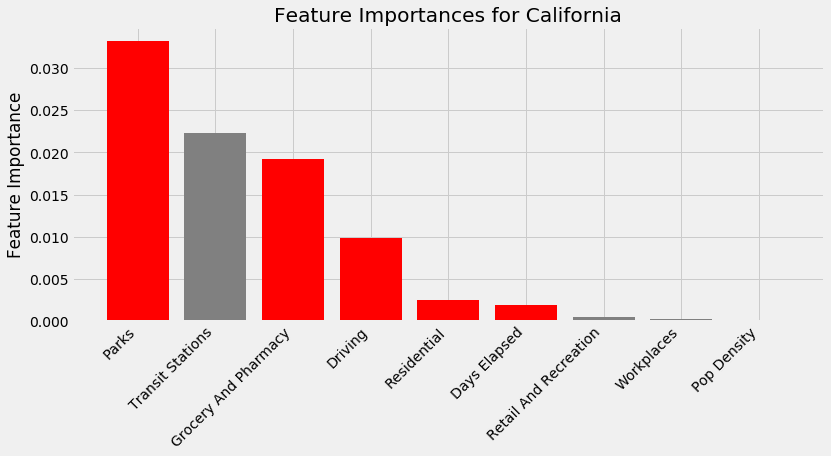

In [58]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
# fig.savefig('images/MN_Feat')

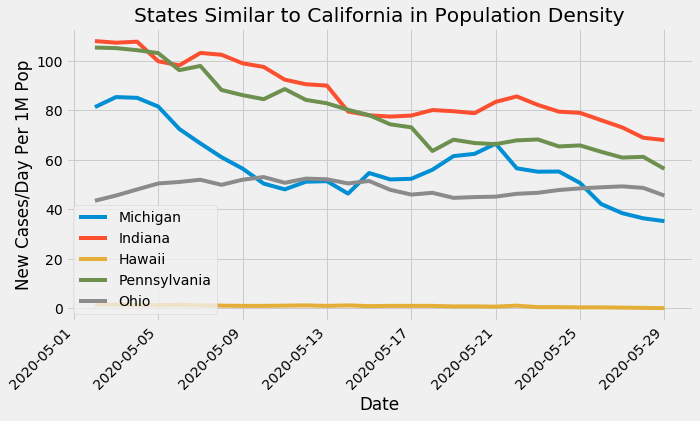

In [59]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

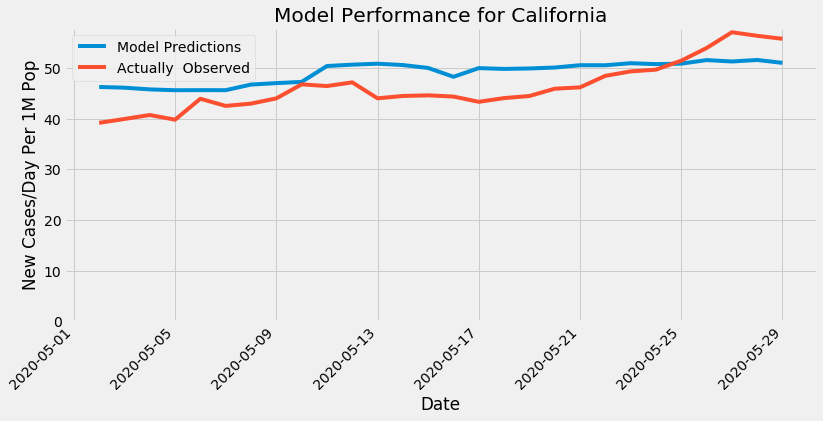

In [60]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

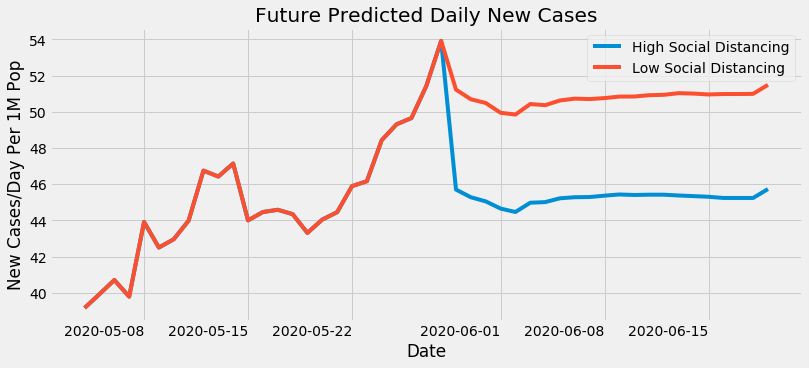

In [61]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [62]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [63]:
SD_Table

,Retail/Recreation %,Grocery/Pharmacy %,Parks %,Transit Stations %,Workplaces %,Residential %,Driving %
,,,,,,,
High,47.29,69.86,36.14,30.43,46.00,121.86,32.89
Low,85.29,103.71,211.00,88.29,68.57,111.57,116.06


In [182]:
state = 'Texas'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 1.0, pop_density_tolerance= 10)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 9.89940331291399
The Most similar states to Texas that meet the comparable parameters are: ['Louisiana' 'Texas' 'Kentucky' 'Washington']. These will be used to predict for Texas.


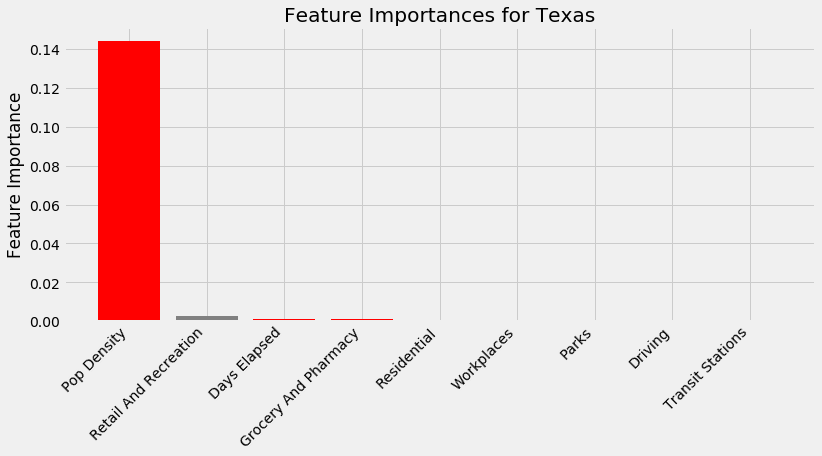

In [183]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
# fig.savefig('images/MN_Feat')

In [15]:
for each in enumerate(np.array(['saf','fdasfa'])):
    print(each)

(0, 'saf')
(1, 'fdasfa')


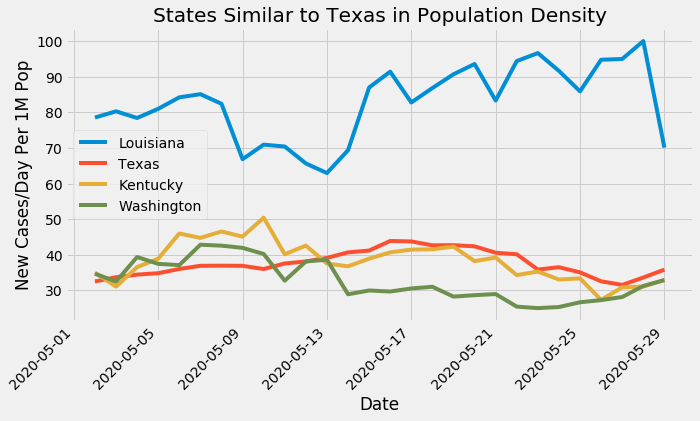

In [184]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

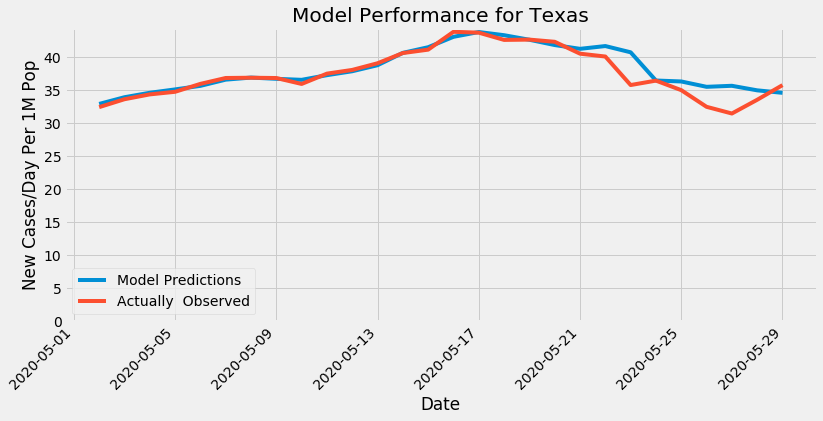

In [185]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

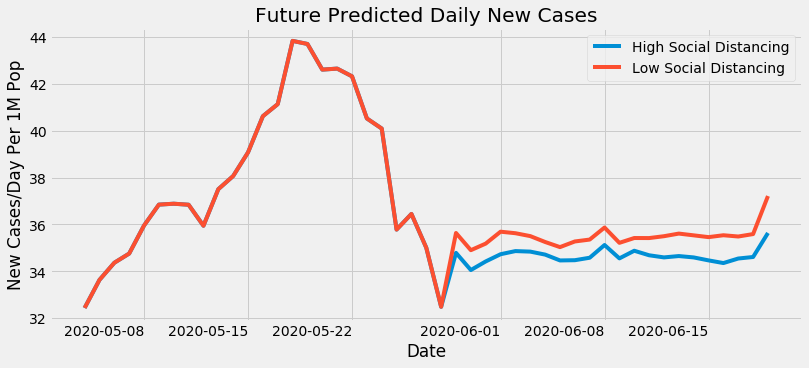

In [186]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [187]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [188]:
SD_Table

,Retail/Recreation %,Grocery/Pharmacy %,Parks %,Transit Stations %,Workplaces %,Residential %,Driving %
,,,,,,,
High,60.86,84.29,76.00,47.29,50.57,118.14,58.23
Low,79.43,106.71,172.43,81.14,70.00,111.14,114.89


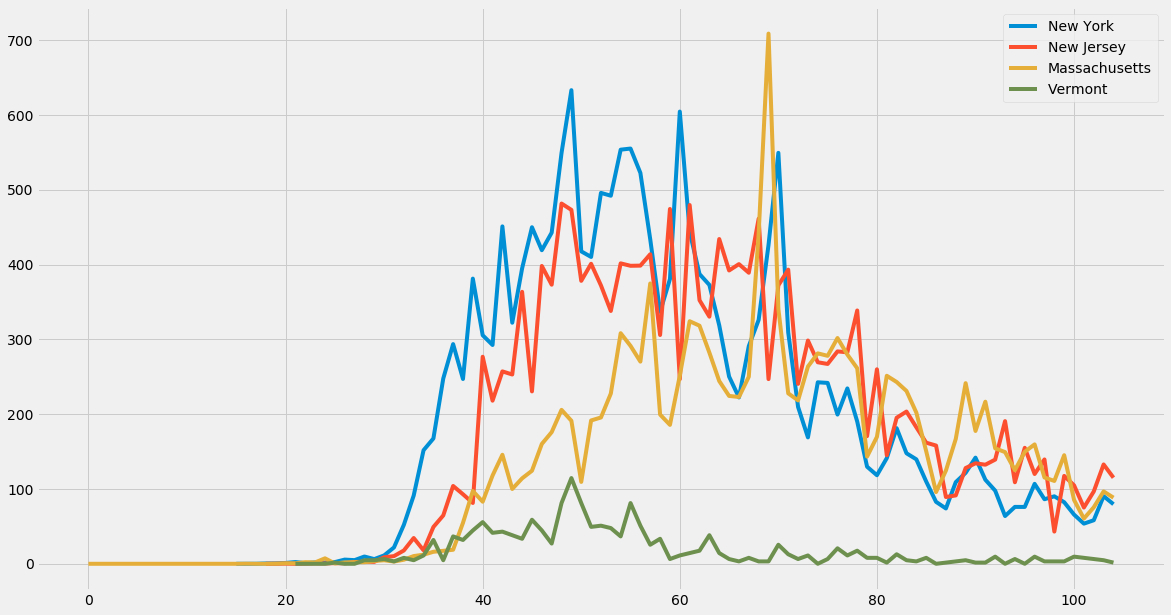

In [611]:
def plot_state(st, type = 'line', label = None):
    st_df = covid_df[covid_df['state'] == st]
    if type == 'line':
        plt.plot(st_df['days_elapsed'], st_df['New_Cases_per_pop'], label = label)
    else:
        plt.scatter(st_df['days_elapsed'], st_df['New_Cases_per_pop'], label = label)
    st_df = st_df.drop(['state', 'pop_density'], axis = 1)
    st_df.index.name = st
    return st_df

fig, axes = plt.subplots(figsize = (18, 10))
plt_type = 'line'
NY_df = plot_state('New York', type = plt_type, label = 'New York')
NJ_df = plot_state('New Jersey', type = plt_type, label = 'New Jersey')
MA_df = plot_state('Massachusetts', type = plt_type, label = 'Massachusetts')
VM_df = plot_state('Vermont', type = plt_type, label = 'Vermont')
plt.legend()

In [140]:
state = 'Wisconsin'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 1, pop_density_tolerance=60)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 5.6658043242474125
The Most similar states to Wisconsin that meet the comparable parameters are: ['Colorado' 'Iowa' 'Oklahoma' 'Arkansas' 'Arizona' 'Vermont' 'Minnesota'
 'West Virginia' 'Missouri' 'Alabama' 'Louisiana' 'Texas' 'Kentucky'
 'Washington' 'New Hampshire' 'Tennessee']. These will be used to predict for Wisconsin.


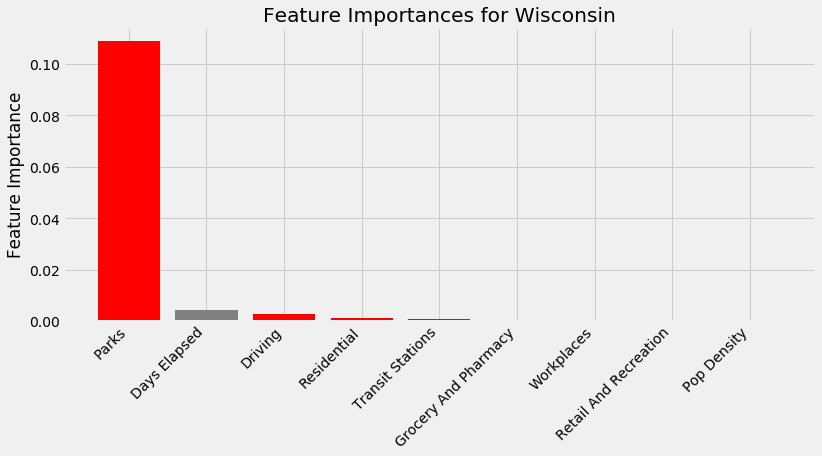

In [141]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
# fig.savefig('images/MN_Feat')

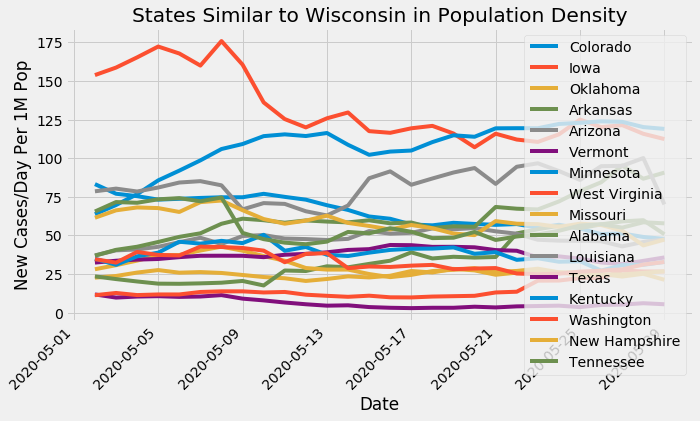

In [142]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

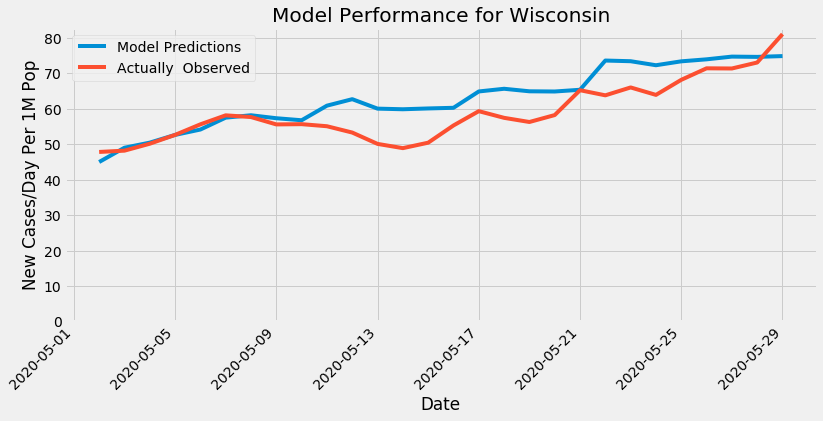

In [143]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

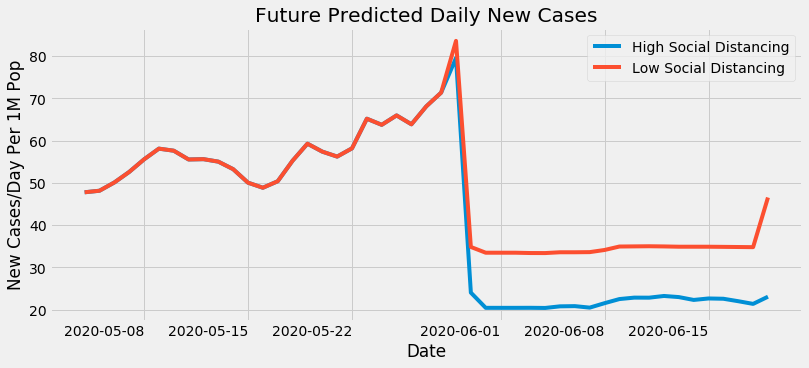

In [144]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [83]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [84]:
SD_Table

,Retail/Recreation %,Grocery/Pharmacy %,Parks %,Transit Stations %,Workplaces %,Residential %,Driving %
,,,,,,,
High,50.00,74.0,78.29,43.29,46.00,121.86,57.08
Low,83.57,105.0,217.71,93.43,70.14,110.00,117.09


In [58]:
round(Similar_States_Init.make_master_pop_dens_df(), 2)

,pop_density,Recovery Factor
state,,
Alaska,1.29,3.14
Wyoming,5.84,2.19
Montana,7.47,17.17
North Dakota,11.04,2.18
South Dakota,11.91,1.55
New Mexico,17.29,1.35
Idaho,22.10,1.75
Nebraska,25.42,1.63
Nevada,28.60,1.26


In [33]:
covid_df = load_and_clean_data()
covid_df = replace

In [6]:
state_list = ['Minnesota', 'Iowa', 'Colorado', 'Missouri', 'Oklahoma', 'Vermont']

Text(0, 0.5, 'Daily New Cases/ 1 M Pop')

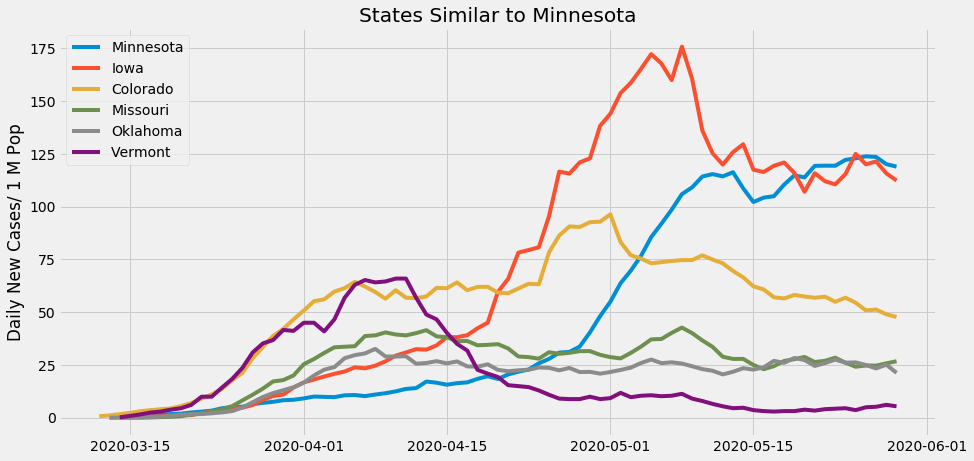

In [9]:
fig, ax = plt.subplots(figsize = (14, 7))
for each in state_list:
    state_df = get_moving_avg_df(covid_df, each, threshold = 0, days_threshold = 0)
    ax.plot(state_df['days_elapsed'].apply(convert_to_date), state_df['Daily_Cases_per_pop'], label = each)
ax.legend()
ax.set_xlabel('')
ax.set_title('States Similar to Minnesota')
ax.set_ylabel('Daily New Cases/ 1 M Pop')

In [10]:
fig.savefig('images/FullDataSetLikeMN')

In [183]:
state_X = Prediction_Insights.State_Analysis_X.copy()
start = 22

In [184]:
state_X.loc[start:, :'Daily_Cases_per_pop(t-1)'] = 0

In [185]:
y_pred = Prediction_Insights.State_Analysis_y.loc[:start-2]

In [186]:
n_rows = state_X.shape[0]
row_start = state_X.shape[0] - state_X[state_X['Daily_Cases_per_pop(t-1)'] == 0].count()[0]
col_start = 20
new_preds = list(y_pred.values)
state_X.iloc[row_start, col_start] = y_pred.values[-1]

IndexError: index -1 is out of bounds for axis 0 with size 0

In [187]:
for row in range(row_start, n_rows):
    for col in range(col_start - 1, -1, -1):
        state_X.iloc[row, col] = state_X.iloc[row - 1, col + 1]

In [188]:
def fill_diagonals(df, preds, model, start_row=31, n_interval=21):
    '''
    Used to populate time lagged observations - diagonal on matrix
    '''
    df.fillna(0, inplace=True)
    n_rows = df.shape[0]
    new_preds = list(preds.values)
    for row in range(start_row, n_rows)[:]:
        new_pred = model.predict(df[row:row + 1])[0]
        new_preds.append(new_pred)
        j = 0
        for col in range(n_interval-1, 0, -1):
            try:
                if df.iloc[row + j, col] == 0:
                    df.iloc[row + j, col] = new_pred
                j += 1
            except:
                continue
    new_pred = model.predict(df[-1:-2:-1])[0]
    new_preds.append(new_pred)
    return df, new_preds

In [189]:
fill_diag_and_predictions = fill_diagonals(
    state_X, y_pred.loc[:start + 1], State_Compile.rf.model, start_row=row_start, n_interval=21)
pred_df = fill_diag_and_predictions[0]
pred_y = fill_diag_and_predictions[1][-pred_df.shape[0]:]

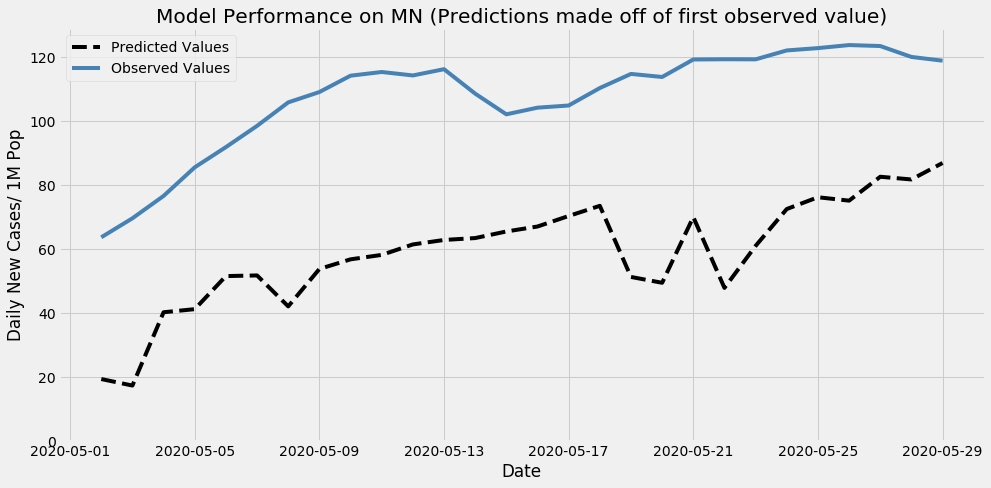

In [190]:
fig, axes = plt.subplots(figsize = (14, 7))

axes.plot(pred_df['days_elapsed(t)'].apply(convert_to_date), pred_y, label = 'Predicted Values', c = 'black', ls = '--')
axes.plot(Prediction_Insights.State_Analysis_X['days_elapsed(t)'].apply(convert_to_date), Prediction_Insights.State_Analysis_y, label = 'Observed Values', c = 'steelblue')
axes.set_ylim(0)
axes.set_xlabel('Date')
axes.set_ylabel('Daily New Cases/ 1M Pop')
axes.set_title("Model Performance on MN (Predictions made off of first observed value)")
axes.legend()
fig.tight_layout()

In [79]:
fig.savefig('images/MNmodelPerf')

In [55]:
Prediction_Insights.State_Analysis_X

,Daily_Cases_per_pop(t-21),Daily_Cases_per_pop(t-20),Daily_Cases_per_pop(t-19),Daily_Cases_per_pop(t-18),Daily_Cases_per_pop(t-17),Daily_Cases_per_pop(t-16),Daily_Cases_per_pop(t-15),Daily_Cases_per_pop(t-14),Daily_Cases_per_pop(t-13),Daily_Cases_per_pop(t-12),...,Daily_Cases_per_pop(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t),pop_density(t)
Minnesota,,,,,,,,,,,,,,,,,,,,,
21,13.682600,14.083555,17.190959,16.639645,15.687376,16.414108,16.790003,18.443944,19.696929,18.418884,...,54.980996,77.0,0.615714,0.875714,1.601429,0.470000,0.561429,1.184286,0.680129,71.592186
22,14.083555,17.190959,16.639645,15.687376,16.414108,16.790003,18.443944,19.696929,18.418884,20.548959,...,63.776953,78.0,0.618571,0.877143,1.654286,0.474286,0.562857,1.181429,0.693671,71.592186
23,17.190959,16.639645,15.687376,16.414108,16.790003,18.443944,19.696929,18.418884,20.548959,21.852064,...,69.716104,79.0,0.621429,0.881429,1.708571,0.475714,0.562857,1.178571,0.704314,71.592186
24,16.639645,15.687376,16.414108,16.790003,18.443944,19.696929,18.418884,20.548959,21.852064,22.854452,...,76.707762,80.0,0.625714,0.888571,1.745714,0.480000,0.564286,1.175714,0.711814,71.592186
25,15.687376,16.414108,16.790003,18.443944,19.696929,18.418884,20.548959,21.852064,22.854452,25.811498,...,85.654077,81.0,0.631429,0.892857,1.787143,0.484286,0.565714,1.172857,0.717729,71.592186
26,16.414108,16.790003,18.443944,19.696929,18.418884,20.548959,21.852064,22.854452,25.811498,27.916513,...,91.969123,82.0,0.644286,0.904286,1.930000,0.494286,0.567143,1.170000,0.730271,71.592186
27,16.790003,18.443944,19.696929,18.418884,20.548959,21.852064,22.854452,25.811498,27.916513,30.898618,...,98.609946,83.0,0.642857,0.901429,1.860000,0.490000,0.565714,1.161429,0.729257,71.592186
28,18.443944,19.696929,18.418884,20.548959,21.852064,22.854452,25.811498,27.916513,30.898618,31.224394,...,105.952440,84.0,0.645714,0.905714,1.774286,0.490000,0.567143,1.161429,0.732543,71.592186
29,19.696929,18.418884,20.548959,21.852064,22.854452,25.811498,27.916513,30.898618,31.224394,33.730365,...,109.185142,85.0,0.657143,0.917143,1.871429,0.498571,0.567143,1.157143,0.748671,71.592186
